We want to analyze participants and patterns of participation across IETF groups. 

Specifically, what are the lengths of participation? Are there new cohorts of participation over time? What is attrition like in IETF mailing list participation? How long do people participate for?

## Setup and gather data

Start by importing the necessary libraries.

In [1]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch
import email
import gc

In [2]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

Let's start with a single IETF mailing list. (Later, we can expand to all current groups, or all IETF lists ever.)

In [4]:
list_url = 'https://www.ietf.org/mail-archive/text/perpass/' # perpass happens to be one that I subscribe to

ietf_archives_dir = '../../ietf-archives' # relative location of the ietf-archives directory/repo

list_archive = mailman.open_list_archives(list_url, ietf_archives_dir)
activity = None
activity = Archive(list_archive).get_activity()

43
Opening 43 archive files


## When do people first send to the mailing list?

For this mailing list, we'll create a histogram of people in the list and when they sent their first message to the list.

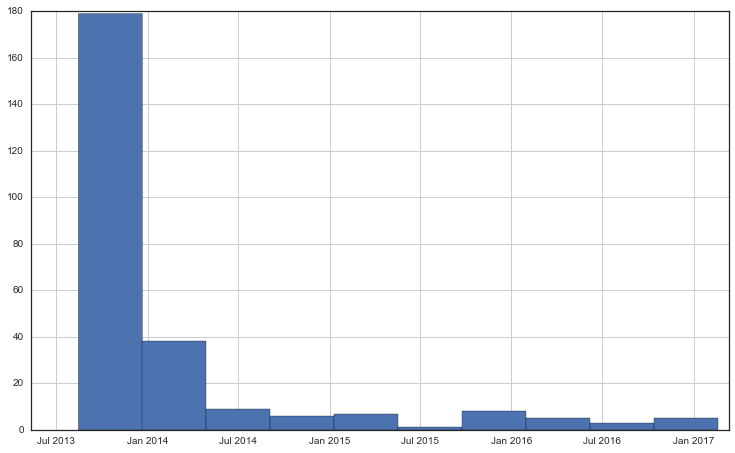

In [5]:
fig = plt.figure(figsize=(12.5, 7.5))

(activity > 0).idxmax().hist()

fig.axes[0].xaxis_date()

For this mailing list, it appears that most people joined the list near the beginning of the list, and few new people join over time.

In [7]:
person_activity = activity.T

In [8]:
def earliest(s):
    just_dates = s.drop(['Earliest Date', 'Latest Date', 'Total Messages', 'Tenure'], errors='ignore')
    
    earliest = None

    if 'Earliest Date' in s.index:
        if pd.notna(s['Earliest Date']):
            earliest = s['Earliest Date']
    
    for i, value in just_dates.iteritems():
        if value > 0:
            if earliest == None or i < earliest:
                earliest = i
    
    return earliest

def latest(s):
    just_dates = s.drop(['Earliest Date', 'Latest Date', 'Total Messages', 'Tenure'], errors='ignore')
    
    latest = None

    if 'Latest Date' in s.index:
        if pd.notna(s['Latest Date']):
            latest = s['Latest Date']
    
    for i, value in just_dates.iteritems():
        if value > 0:
            if latest == None or i > latest:
                latest = i
    
    return latest

def total_messages(s): # this is a cumulative sum
    just_dates = s.drop(['Earliest Date', 'Latest Date', 'Tenure'], errors='ignore')
    return just_dates.sum()

person_activity['Earliest Date'] = person_activity.apply(earliest, axis='columns')
person_activity['Latest Date'] = person_activity.apply(latest, axis='columns')
person_activity['Total Messages'] = person_activity.apply(total_messages, axis='columns')
person_activity.describe()

Date,735095,735096,735097,735098,735099,735100,735101,735102,735103,735104,...,736514,736515,736516,736517,736518,736519,736520,Earliest Date,Latest Date,Total Messages
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.0,261.0,261.0,...,261.0,261.0,261.0,261.0,261.0,261.0,261.0,261.000000,261.000000,261.000000
mean,0.007663,0.003831,0.091954,0.034483,0.030651,0.019157,0.022989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735275.938697,735461.072797,8.015326
std,0.087369,0.061898,0.546996,0.253359,0.261319,0.222781,0.213596,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,274.335119,380.839536,18.733961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735095.000000,735095.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735124.000000,735178.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735164.000000,735290.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735280.000000,735707.000000,7.000000
max,1.000000,1.000000,6.000000,3.000000,3.000000,3.000000,2.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,736378.000000,736507.000000,231.000000


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


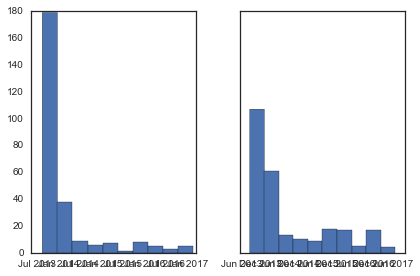

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(person_activity['Earliest Date'])
axs[1].hist(person_activity['Latest Date'])
axs[0].xaxis_date()
axs[1].xaxis_date()

On the left, how many people sent their first message; on the right, how many people on that date sent their last message to the list. This is pretty spiky for both, people started early, and many of them stopped after that initial burst of activity.

In [10]:
gc.collect()

5980

## When do people first join any IETF list?

We want to combine these activity frames where the values are the number of messages sent on that date.

In [11]:
f = open('ietf_lists_normalized.txt', 'r')
ietf_lists = list(set(f.readlines())) # remove duplicates, which is a bug in list maintenance

In [12]:
running_activity = person_activity[['Earliest Date', 'Latest Date', 'Total Messages']]

# todo export the combined file at regular intervals?

In [18]:
running_activity.to_csv('participation-length.csv', encoding='utf-8')

In [ ]:
for i_list in ietf_lists[1:4]: # can run this a few at a time, or in bulk if working smoothly
    logging.info('Opening %s', i_list)
    try:
        i_list_archive = mailman.open_list_archives(i_list, ietf_archives_dir)
        i_activity = Archive(i_list_archive).get_activity().T
        running_activity = pd.merge(running_activity, i_activity, how='outer', left_index=True, right_index=True) 
        running_activity['Earliest Date'] = running_activity.apply(earliest, axis='columns')
        running_activity['Latest Date'] = running_activity.apply(latest, axis='columns')
        running_activity['Total Messages'] = running_activity.apply(total_messages, axis='columns')
    except mailman.MissingDataException:
        logging.error('Looks like an empty list archive', exc_info=True)
    running_activity = running_activity[['Earliest Date', 'Latest Date', 'Total Messages']]
    gc.collect()

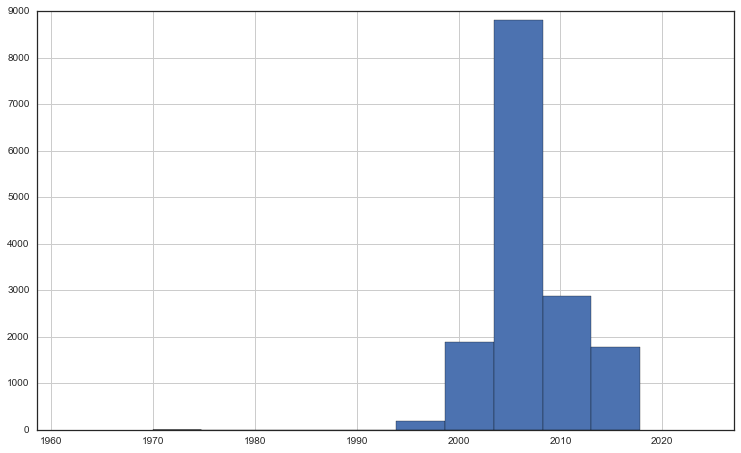

In [55]:
fig = plt.figure(figsize=(12.5, 7.5))
running_activity['Earliest Date'].hist()
fig.axes[0].xaxis_date()

We have a peak in mid-2000s on new participation (that might also just be where the peak of this corpus of messages is present).

We can calculate a "tenure" concept, which is the number of days between your first message to an IETF list and your latest message.

In [ ]:
running_activity['Tenure'] = running_activity['Latest Date'] - running_activity['Earliest Date']

In [30]:
running_activity.describe()

Date,Earliest Date,Latest Date,Total Messages,Tenure
count,12778.000000,12778.000000,12784.000000,12778.000000
mean,732816.413602,732996.813977,9.702519,180.400376
std,1452.368451,1546.950284,55.877373,558.198874
min,719163.000000,722914.000000,0.000000,0.000000
25%,732170.250000,732324.000000,1.000000,0.000000
50%,732868.000000,732914.000000,1.000000,0.000000
75%,733239.000000,733573.750000,3.000000,20.000000
max,736623.000000,736625.000000,2232.000000,12761.000000


Let's graph data for people for whom we have at least a few messages.

In [42]:
working_data = running_activity[running_activity['Total Messages'] > 5]

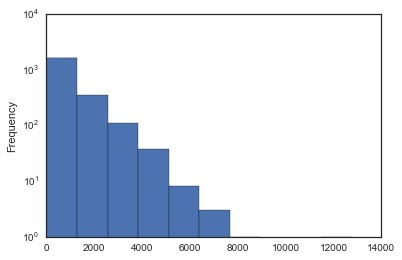

In [51]:
working_data['Tenure'].plot(kind ='hist',logy=True)

The distribution of tenure seems to be exactly a power law. (The above graph is log scale in the y dimension.) Most people have short tenures, and length of tenure decays over time.

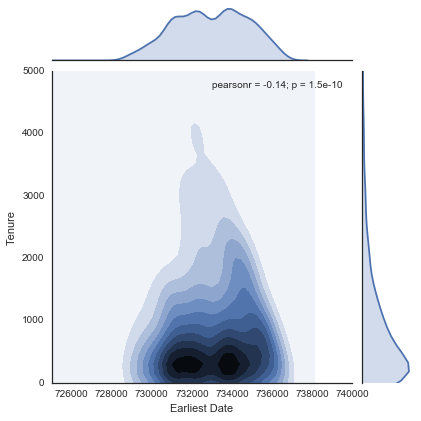

In [48]:
fig = sns.jointplot(kind='kde', data = working_data, x='Earliest Date', y='Tenure', xlim=(725000,740000), ylim=(0, 5000))